In [1]:
import os
import sys
import math
import sklearn
import matplotlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm


from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Paths

In [2]:
CSV_PATH = "complete-frame.csv"
CSV_MINER_PATH = "testminereffectiveness.csv"

# Load All the data

In [3]:
def label_rename (row):
    return row['path_test'].split('/')[len(row['path_test'].split('/')) - 1].split('.')[0]

def load_frame():
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame = pd.merge(frame1, frame2, on='TestClassName')
    frame = frame.drop(['project', 'module', 'path_test','test_name','path_src',
                        'class_name','TestClassName','commit','Nº','Project'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame


def load_static_frame():
    frame1 = pd.read_csv(CSV_PATH, sep=",")
    frame1 = frame1.sample(frac=1).reset_index(drop=True)
    frame1['TestClassName'] = frame1.apply(lambda row: label_rename(row), axis=1)
    frame2 = pd.read_csv(CSV_MINER_PATH, sep=',')
    frame = pd.merge(frame1, frame2, on='TestClassName')
    frame = frame.drop(['project', 'module', 'path_test','test_name','path_src',
                        'class_name','TestClassName','commit','Nº','Project'], axis=1)
    frame = frame.sample(frac=1).reset_index(drop=True)
    frame = frame.dropna()

    return frame


def load_quartile(frame):
    low, high = frame.mutation.quantile([0.25,0.75])
    frame_low = frame.query('mutation<{low}'.format(low=low))
    frame_high = frame.query('mutation>{high}'.format(high=high))
    frame_low['mutation'] = 0
    frame_high['mutation'] = 1
    frame = pd.concat([frame_low, frame_high], ignore_index=True)
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame;

def load_meaningful_subset(frame):
    columns = [frame.no_mutations,
                         frame.line_coverage,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)


def load_meaningful_subset_static(frame):
    columns = [frame.no_mutations,
                         frame.csm_FE,
                         frame.CONNECTIVITY_prod,
                         frame.CONNECTIVITY_test,
                         frame.isEagerTest,
                         frame.LOC_prod, frame.LOC_test, frame.WMC_prod,
                         frame.LCOM1_prod, frame.LCOM2_prod,
                         frame.LCOM4_prod, frame.McCABE_prod,
                         frame.RFC_prod, frame.MPC_prod,
                         frame.RFC_test, frame.MPC_test,
                         frame.LCOM1_test, frame.LCOM2_test,
                         frame.LCOM4_test, frame.LCC_test,
                         frame.LCC_test, frame.WMC_test,
                         frame.McCABE_test, frame.NOP_prod]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

def load_meaningful_subset_2(frame):
    #columns = [frame.line_coverage, frame.isAssertionRoulette, frame.isMysteryGuest,
    #   frame.isResourceOptimism, frame.isForTestersOnly, frame.COH_prod, frame.BUSWEIMER_prod,
    #   frame.BUSWEIMER_test, frame.csm_LM, frame.prod_readability]
    
    [frame.line_coverage,
    frame.COH_prod, frame.BUSWEIMER_prod, frame.csm_MC,
       frame.prod_readability, frame.prod_readability]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)




def load_all_data(frame):
    columns = [frame.no_mutations, frame.line_coverage, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)
    

def load_all_data_with_mine(frame):
    columns = [frame.no_mutations, frame.line_coverage, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability,frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)


def load_all_data_static(frame):
    columns = [frame.no_mutations, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)
    

def load_all_data_with_mine_static(frame):
    columns = [frame.no_mutations, frame.isAssertionRoulette, frame.isEagerTest, frame.isLazyTest,
frame.isMysteryGuest, frame.isSensitiveEquality, frame.isResourceOptimism, frame.isForTestersOnly,
frame.isIndirectTesting, frame.LOC_prod, frame.HALSTEAD_prod, frame.RFC_prod, frame.CBO_prod, frame.MPC_prod, frame.IFC_prod, frame.DAC_prod,frame.DAC2_prod, frame.LCOM1_prod, frame.LCOM2_prod,
frame.LCOM3_prod, frame.LCOM4_prod, frame.CONNECTIVITY_prod, frame.LCOM5_prod, frame.COH_prod, frame.TCC_prod,
frame.LCC_prod, frame.ICH_prod, frame.WMC_prod, frame.NOA_prod, frame.NOPA_prod, frame.NOP_prod,
frame.McCABE_prod, frame.BUSWEIMER_prod, frame.LOC_test, frame.HALSTEAD_test, frame.RFC_test, frame.CBO_test,
frame.MPC_test, frame.IFC_test, frame.DAC_test, frame.DAC2_test, frame.LCOM1_test, frame.LCOM2_test,
frame.LCOM3_test, frame.LCOM4_test, frame.CONNECTIVITY_test, frame.LCOM5_test, frame.COH_test, frame.TCC_test,
frame.LCC_test, frame.ICH_test, frame.WMC_test, frame.NOA_test, frame.NOPA_test, frame.NOP_test, frame.McCABE_test,
frame.BUSWEIMER_test, frame.csm_CDSBP, frame.csm_CC, frame.csm_FD, frame.csm_Blob, frame.csm_SC, frame.csm_MC,
frame.csm_LM, frame.csm_FE, frame.prod_readability, frame.test_readability,frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters]
    
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

def load_mine(frame):
    columns = [frame.Assrtions, frame.Conditions,frame.TryCatch, frame.Loop,frame.Hamcrest,frame.Mockito,
           frame.BadApi,frame.LOC,frame.Expressions, frame.Depth, frame.Vocabulary,
           frame.Understandability,frame.BodySize, frame.Dexterity, frame.NonWhiteCharacters, frame.mutation]
    data_x = pd.concat(columns, axis = 1).round(2)
    data_y = pd.concat([frame.mutation], axis = 1)
    return data_x, data_y, len(columns)

# Grid - Static with all their data + my data

In [27]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', activation='linear', init_mode='uniform', dropout_rate=0.1):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(dropout_rate, input_shape=(82,)))
    model.add(keras.layers.Dense(40, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(20, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(2, kernel_initializer=init_mode, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)


early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=10, verbose=0, mode='max', restore_best_weights=True)

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=2000)

# define the grid search parameters
batch_size = [10] #, 20, 40, 60, 80, 100]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.2, 0.25, 0.3]
param_grid = dict(batch_size=batch_size, optimizer=optimizer, activation=activation, dropout_rate=dropout_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)



grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=kfold, verbose=2)
grid_result = grid.fit(data_x, data_y, callbacks=[early_stopping_monitor])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Dor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 168 candidates, totalling 1680 fits
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   6.4s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.5s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.3s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.3s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.9s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.5s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.1s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=softmax, batch_si

[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=  14.7s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=  21.8s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=  11.2s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=  14.4s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=  20.1s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=  13.7s
[CV] activation=softmax, batch_size=10, dropout_rate=0.2, optimizer=Adamax

[CV]  activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   3.6s
[CV] activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   5.1s
[CV] activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   3.5s
[CV] activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   3.6s
[CV] activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   3.5s
[CV] activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   3.5s
[CV] activation=softmax, batch_size=10, d

[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=  16.4s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=  11.1s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=  10.7s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=  15.7s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=  13.9s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=  10.3s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optim

[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Adamax, total=  15.2s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam, total=  12.5s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam, total=  13.0s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam, total=  24.8s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam, total=  19.7s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam 
[CV]  activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam, total=  11.8s
[CV] activation=softmax, batch_size=10, dropout_rate=0.3, optimizer=Nadam 
[CV]  act

[CV]  activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adadelta, total=   3.0s
[CV] activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adadelta 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adadelta, total=   3.0s
[CV] activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adam, total=   8.2s
[CV] activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adam, total=  10.1s
[CV] activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adam, total=   6.4s
[CV] activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adam, total=   9.5s
[CV] activation=softplus, batch_size=10, dropout_rate=0.2, optimizer=Adam

[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=RMSprop, total=   8.7s
[CV] activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=RMSprop 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=RMSprop, total=   9.1s
[CV] activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=RMSprop 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=RMSprop, total=   5.1s
[CV] activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Adagrad 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Adagrad, total=  14.8s
[CV] activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Adagrad 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Adagrad, total=   6.1s
[CV] activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Adagrad 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Adagrad, total=   7.4s
[CV] activation=softplus, batch_size=10, 

[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Nadam, total=   7.3s
[CV] activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Nadam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Nadam, total=   9.3s
[CV] activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Nadam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Nadam, total=  16.6s
[CV] activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Nadam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Nadam, total=   7.6s
[CV] activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Nadam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.25, optimizer=Nadam, total=  15.2s
[CV] activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=SGD 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=SGD, total=  12.6s
[CV] activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=

[CV]  activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam, total=   5.3s
[CV] activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam, total=   6.3s
[CV] activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam, total=  12.5s
[CV] activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam, total=  10.0s
[CV] activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam, total=   7.5s
[CV] activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam 
[CV]  activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adam, total=  13.8s
[CV] activation=softplus, batch_size=10, dropout_rate=0.3, optimizer=Adamax 
[CV]  ac

[CV]  activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad, total=   6.7s
[CV] activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad, total=   6.9s
[CV] activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad, total=   4.6s
[CV] activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad, total=   7.2s
[CV] activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad, total=   4.7s
[CV] activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.2, optimizer=Adagrad, total=   5.8s
[CV] activation=softsign, batch_size=10, dropout_rat

[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD, total=   8.7s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD, total=   7.6s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD, total=   9.8s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD, total=   7.2s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD, total=  12.2s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD, total=   7.3s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=SGD 
[CV]  acti

[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax, total=   8.9s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax, total=   8.2s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax, total=   4.3s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax, total=   5.0s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax, total=   5.8s
[CV] activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.25, optimizer=Adamax, total=   6.5s
[CV] activation=softsign, batch_size=10, dropout_rat

[CV]  activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   8.4s
[CV] activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=  12.5s
[CV] activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=  15.9s
[CV] activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=   9.0s
[CV] activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=  15.7s
[CV] activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=softsign, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=   9.7s
[CV] activation=softsign, batch_size=10, d

[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=  15.9s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=  12.4s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=  15.4s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=  18.6s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=  14.0s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=  15.3s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=relu, bat

[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=  11.9s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=  17.1s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=  12.3s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=   7.4s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=  15.8s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=  12.7s
[CV] activation=relu, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=relu, batch_size=10, dropout_

[CV]  activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=  15.7s
[CV] activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=  17.7s
[CV] activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=  19.4s
[CV] activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=  22.3s
[CV] activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=  21.5s
[CV] activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=  21.9s
[CV] activation=relu, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=relu, batch_size=10, dropout_

[CV]  activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   6.8s
[CV] activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   4.1s
[CV] activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   5.0s
[CV] activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   6.6s
[CV] activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   3.6s
[CV] activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   8.5s
[CV] activation=relu, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=relu,

[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   9.2s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=SGD .
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   5.1s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=SGD .
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   6.7s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=SGD .
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   6.6s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=SGD .
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   5.3s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=  17.7s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2

[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=   6.3s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=   5.3s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=   7.8s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=   5.7s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=  24.7s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=  11.0s
[CV] activation=tanh, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=tanh, batch_size=10, d

[CV]  activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=  11.3s
[CV] activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=  12.5s
[CV] activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=  13.6s
[CV] activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=  16.3s
[CV] activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=  16.2s
[CV] activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=  10.8s
[CV] activation=tanh, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=tanh, bat

[CV]  activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=  12.4s
[CV] activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=   4.9s
[CV] activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   6.4s
[CV] activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   6.8s
[CV] activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   7.7s
[CV] activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   7.9s
[CV] activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=tanh,

[CV]  activation=tanh, batch_size=10, dropout_rate=0.3, optimizer=Nadam, total=  16.6s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   2.7s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.2s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   4.5s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   4.5s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD, total=   3.7s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=SGD 
[CV]  activation=sigmoid, batch_siz

[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adam, total=   5.5s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=   6.3s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=   8.8s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=   5.7s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=   6.6s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax, total=   7.4s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adamax 


[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adagrad, total=   4.9s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adagrad 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adagrad, total=   5.2s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   2.9s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   2.8s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   3.6s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adadelta 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adadelta, total=   2.9s
[CV] activation=sigmoid, batch_size=10, drop

[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=SGD, total=   2.6s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=SGD 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=SGD, total=   3.9s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=SGD 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=SGD, total=   4.9s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=   7.9s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=   5.5s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=RMSprop, total=   5.2s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=RMSprop 
[CV]  

[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adamax, total=   5.6s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adamax 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adamax, total=  12.4s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adamax 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adamax, total=   9.7s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adamax 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adamax, total=   7.9s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Nadam 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Nadam, total=   6.7s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Nadam 
[CV]  activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Nadam, total=   7.9s
[CV] activation=sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Nadam 
[CV

[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta, total=   6.5s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta, total=   6.6s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta, total=   6.3s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta, total=   6.8s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta, total=   6.6s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.2, optimizer=Adadelta, total=   6.

[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop, total=  22.4s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop, total=  14.3s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop, total=  16.8s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop, total=  19.6s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop, total=  11.4s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=RMSprop, total=  18.

[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adamax, total=   9.8s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adamax 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adamax, total=   9.2s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adamax 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Adamax, total=  11.6s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Nadam 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Nadam, total=   9.9s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Nadam 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Nadam, total=  11.0s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Nadam 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.25, optimizer=Nadam, total=  10.4s
[CV] activatio

[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=   3.5s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=   3.6s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=   7.9s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=   4.0s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=   3.5s
[CV] activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta 
[CV]  activation=hard_sigmoid, batch_size=10, dropout_rate=0.3, optimizer=Adadelta, total=   3.

[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=   8.3s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=   6.0s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=   6.5s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=   7.4s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=   4.5s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop, total=   4.7s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=RMSprop

[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=   5.7s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=   7.6s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=   5.3s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=  10.3s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=   7.1s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam, total=   7.1s
[CV] activation=linear, batch_size=10, dropout_rate=0.2, optimizer=Nadam 
[CV]  activation=linea

[CV]  activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=   5.3s
[CV] activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=   4.7s
[CV] activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=   5.2s
[CV] activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=   7.4s
[CV] activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=   5.2s
[CV] activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam, total=   4.5s
[CV] activation=linear, batch_size=10, dropout_rate=0.25, optimizer=Adam 
[CV]  activation=linea

[CV]  activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   6.5s
[CV] activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=  11.5s
[CV] activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   4.2s
[CV] activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   6.7s
[CV] activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   7.9s
[CV] activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad 
[CV]  activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad, total=   8.0s
[CV] activation=linear, batch_size=10, dropout_rate=0.3, optimizer=Adagrad

[Parallel(n_jobs=1)]: Done 1680 out of 1680 | elapsed: 286.5min finished


Best: 0.898978 using {'activation': 'relu', 'batch_size': 10, 'dropout_rate': 0.25, 'optimizer': 'Adam'}
0.500000 (0.002014) with: {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.2, 'optimizer': 'SGD'}
0.876577 (0.023520) with: {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.2, 'optimizer': 'RMSprop'}
0.550346 (0.119048) with: {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.2, 'optimizer': 'Adagrad'}
0.500901 (0.001802) with: {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.2, 'optimizer': 'Adadelta'}
0.884612 (0.027356) with: {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.2, 'optimizer': 'Adam'}
0.857794 (0.029983) with: {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.2, 'optimizer': 'Adamax'}
0.889085 (0.023487) with: {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.2, 'optimizer': 'Nadam'}
0.500901 (0.001802) with: {'activation': 'softmax', 'batch_size': 10, 'dropout_rate': 0.25, 'optimi

# Grid - predict the exact mutation score value (Dynamic)

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', activation='linear', init_mode='uniform', dropout_rate=0.1):
    model = keras.Sequential()
    model.add(keras.layers.Dropout(dropout_rate, input_shape=(82,)))
    model.add(keras.layers.Dense(40, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(20, kernel_initializer=init_mode, activation=activation))
    model.add(keras.layers.Dense(2, kernel_initializer=init_mode, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
frame = load_frame()
frame = load_quartile(frame)

data_x, data_y, number_of_features = load_all_data_with_mine_static(frame)

data_x = data_x.values
data_y = data_y.values

scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)


early_stopping_monitor = keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.0003, patience=10, verbose=0, mode='max', restore_best_weights=True)

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=2000)

# define the grid search parameters
batch_size = [10] #, 20, 40, 60, 80, 100]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.2, 0.25, 0.3]
param_grid = dict(batch_size=batch_size, optimizer=optimizer, activation=activation, dropout_rate=dropout_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)



grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=kfold, verbose=2)
grid_result = grid.fit(data_x, data_y, callbacks=[early_stopping_monitor])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

(1570, 25)
Train on 1570 samples, validate on 336 samples
Epoch 1/1000
1570/1570 [==============================] - 1s 603us/sample - loss: 0.1760 - mae: 0.3061 - val_loss: 0.0817 - val_mae: 0.2318
Epoch 2/1000
1570/1570 [==============================] - 0s 96us/sample - loss: 0.0603 - mae: 0.1905 - val_loss: 0.0475 - val_mae: 0.1749
Epoch 3/1000
1570/1570 [==============================] - 0s 95us/sample - loss: 0.0420 - mae: 0.1561 - val_loss: 0.0419 - val_mae: 0.1633
Epoch 4/1000
1570/1570 [==============================] - 0s 93us/sample - loss: 0.0346 - mae: 0.1446 - val_loss: 0.0352 - val_mae: 0.1503
Epoch 5/1000
1570/1570 [==============================] - 0s 94us/sample - loss: 0.0310 - mae: 0.1357 - val_loss: 0.0339 - val_mae: 0.1469
Epoch 6/1000
1570/1570 [==============================] - 0s 97us/sample - loss: 0.0287 - mae: 0.1291 - val_loss: 0.0325 - val_mae: 0.1425
Epoch 7/1000
1570/1570 [==============================] - 0s 100us/sample - loss: 0.0273 - mae: 0.1240 - va

1570/1570 [==============================] - 0s 97us/sample - loss: 0.0151 - mae: 0.0882 - val_loss: 0.0263 - val_mae: 0.1184
Epoch 60/1000
1570/1570 [==============================] - 0s 96us/sample - loss: 0.0158 - mae: 0.0902 - val_loss: 0.0246 - val_mae: 0.1184
Epoch 61/1000
1570/1570 [==============================] - 0s 97us/sample - loss: 0.0153 - mae: 0.0891 - val_loss: 0.0267 - val_mae: 0.1166
Epoch 62/1000
1570/1570 [==============================] - 0s 98us/sample - loss: 0.0151 - mae: 0.0881 - val_loss: 0.0245 - val_mae: 0.1143
Epoch 63/1000
1570/1570 [==============================] - 0s 104us/sample - loss: 0.0156 - mae: 0.0876 - val_loss: 0.0250 - val_mae: 0.1172
Epoch 64/1000
1570/1570 [==============================] - 0s 97us/sample - loss: 0.0151 - mae: 0.0879 - val_loss: 0.0265 - val_mae: 0.1207
Epoch 65/1000
1570/1570 [==============================] - 0s 94us/sample - loss: 0.0147 - mae: 0.0870 - val_loss: 0.0254 - val_mae: 0.1195
Epoch 66/1000
1570/1570 [========

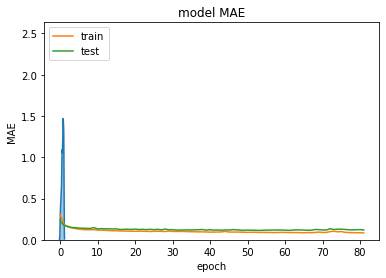

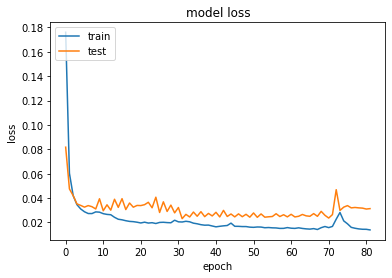

Model Accuracy: 0.1340799480676651
Overfit checks:
Model Accuracy: 0.09953203797340393


In [48]:
def silent_evaluation(model, x_test, y_test):
    f = open('/dev/null', 'w')
    regular_stdout = sys.stdout
    sys.stdout = f
    test_loss, test_acc = model.evaluate(x_test, y_test)
    sys.stdout = regular_stdout
    print('Model Accuracy: {}'.format(test_acc))
    
def split_data(train_x, train_y, training=0.70, validation=0.5):
    train_size = training

    train_cnt = math.floor(train_x.shape[0] * train_size)
    x_train = train_x[0:train_cnt]
    y_train = train_y[0:train_cnt]
    x_test = train_x[train_cnt:]
    y_test = train_y[train_cnt:]

    division = validation

    train_cnt = math.floor(x_test.shape[0] * division)
    x_validate = x_test[0:train_cnt]
    y_validate = y_test[0:train_cnt]
    x_test = x_test[train_cnt:]
    y_test = y_test[train_cnt:]

    return x_train, y_train, x_test, y_test, x_validate, y_validate    

frame = load_frame()
data_x, data_y, number_of_features = load_meaningful_subset(frame)
data_y = pd.concat([frame.mutation], axis = 1).round(2).values


scaler = StandardScaler()
scaler.fit(data_x)
data_x = scaler.transform(data_x)

sns.distplot(data_y);


x_train, y_train, x_test, y_test, x_validate, y_validate = split_data(data_x, data_y)

print(x_train.shape)
model = keras.Sequential()
model.add(keras.layers.Dense(number_of_features, activation='relu', input_dim=number_of_features))
model.add(keras.layers.Dense(40, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

early_stopping_monitor = keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)


history = model.fit(x_train, y_train, epochs=1000, verbose=1, validation_data=(x_validate, y_validate),
                    callbacks=[early_stopping_monitor])


# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

silent_evaluation(model, x_test, y_test)


print("Overfit checks:")
silent_evaluation(model, x_train, y_train)

In [49]:
y_pred = model.predict(x_test)
y_pred = np.concatenate(y_pred).tolist()
y_pred


[0.6493157744407654,
 0.6235284805297852,
 0.409065306186676,
 0.8036282062530518,
 0.1475561261177063,
 0.8172507882118225,
 0.6712965965270996,
 0.7556335926055908,
 0.845294177532196,
 0.2664996385574341,
 0.7334466576576233,
 0.7235182523727417,
 0.5217807292938232,
 0.7529882192611694,
 0.4862895607948303,
 0.8229130506515503,
 0.8322136998176575,
 0.4084024429321289,
 0.9095289707183838,
 0.8171208500862122,
 0.7998390793800354,
 0.037189461290836334,
 0.6389078497886658,
 0.6923748850822449,
 1.0108826160430908,
 0.8343718647956848,
 0.5367078185081482,
 0.8873881697654724,
 0.927151083946228,
 0.7767894864082336,
 0.9824255704879761,
 0.6998414397239685,
 0.9346991777420044,
 0.8242970705032349,
 0.8536975979804993,
 0.7026914954185486,
 0.5588530898094177,
 0.5353091359138489,
 0.45884937047958374,
 0.7434186935424805,
 0.7485308647155762,
 0.6152995228767395,
 0.7876898050308228,
 0.5905715227127075,
 0.8297582864761353,
 0.08778990805149078,
 -0.012580133974552155,
 0.814716

In [50]:
y_testi = np.concatenate(y_test).tolist()
y_testi

[0.73,
 0.35,
 0.42,
 0.95,
 0.04,
 0.7,
 0.51,
 0.87,
 0.64,
 0.98,
 0.75,
 0.86,
 0.5,
 0.48,
 0.41,
 0.82,
 1.0,
 1.0,
 1.0,
 0.94,
 0.8,
 0.02,
 0.64,
 0.79,
 1.0,
 0.9,
 0.78,
 0.83,
 1.0,
 0.7,
 0.88,
 0.9,
 0.95,
 0.89,
 0.86,
 0.67,
 0.62,
 0.45,
 0.14,
 0.25,
 0.91,
 0.14,
 0.96,
 0.46,
 0.92,
 0.14,
 0.08,
 0.81,
 0.44,
 0.92,
 0.88,
 1.0,
 1.0,
 0.28,
 0.42,
 0.74,
 0.69,
 0.83,
 0.5,
 0.52,
 0.92,
 0.16,
 1.0,
 0.8,
 0.61,
 0.6,
 0.86,
 0.72,
 0.53,
 0.51,
 0.81,
 0.79,
 0.81,
 0.54,
 0.29,
 0.46,
 0.09,
 0.58,
 0.14,
 0.67,
 0.09,
 0.92,
 0.21,
 0.78,
 1.0,
 0.84,
 0.71,
 0.59,
 0.62,
 0.88,
 0.8,
 0.43,
 0.63,
 0.5,
 0.49,
 0.59,
 0.54,
 0.54,
 0.81,
 0.86,
 0.33,
 1.0,
 0.87,
 0.81,
 0.58,
 0.35,
 0.15,
 0.48,
 1.0,
 0.67,
 1.0,
 0.67,
 0.01,
 0.18,
 0.5,
 0.51,
 0.64,
 1.0,
 0.79,
 0.07,
 0.78,
 0.61,
 0.12,
 0.32,
 0.47,
 0.49,
 0.5,
 0.89,
 0.9,
 0.28,
 0.85,
 0.83,
 0.21,
 1.0,
 0.79,
 0.05,
 0.58,
 0.12,
 0.22,
 0.4,
 0.65,
 0.84,
 0.29,
 0.93,
 0.74,
 0.76,
 0.36,


In [83]:
#err = y_test - y_pred
err = [abs(e1 - e2) for e1, e2 in zip(y_test,y_pred)]
err = np.concatenate(err).tolist()
err

[0.0806842255592346,
 0.2735284805297852,
 0.010934693813323959,
 0.1463717937469482,
 0.10755612611770629,
 0.11725078821182255,
 0.1612965965270996,
 0.11436640739440918,
 0.20529417753219603,
 0.7135003614425659,
 0.01655334234237671,
 0.1364817476272583,
 0.021780729293823242,
 0.27298821926116945,
 0.07628956079483035,
 0.002913050651550342,
 0.16778630018234253,
 0.5915975570678711,
 0.09047102928161621,
 0.12287914991378779,
 0.00016092061996464402,
 0.017189461290836334,
 0.0010921502113342418,
 0.09762511491775516,
 0.01088261604309082,
 0.06562813520431521,
 0.24329218149185183,
 0.05738816976547245,
 0.07284891605377197,
 0.07678948640823369,
 0.10242557048797607,
 0.20015856027603152,
 0.015300822257995561,
 0.06570292949676515,
 0.006302402019500719,
 0.032691495418548544,
 0.06114691019058227,
 0.08530913591384887,
 0.3188493704795837,
 0.49341869354248047,
 0.16146913528442386,
 0.4752995228767395,
 0.1723101949691772,
 0.1305715227127075,
 0.09024171352386479,
 0.052210

In [84]:
list(zip(y_testi,err))

[(0.73, 0.0806842255592346),
 (0.35, 0.2735284805297852),
 (0.42, 0.010934693813323959),
 (0.95, 0.1463717937469482),
 (0.04, 0.10755612611770629),
 (0.7, 0.11725078821182255),
 (0.51, 0.1612965965270996),
 (0.87, 0.11436640739440918),
 (0.64, 0.20529417753219603),
 (0.98, 0.7135003614425659),
 (0.75, 0.01655334234237671),
 (0.86, 0.1364817476272583),
 (0.5, 0.021780729293823242),
 (0.48, 0.27298821926116945),
 (0.41, 0.07628956079483035),
 (0.82, 0.002913050651550342),
 (1.0, 0.16778630018234253),
 (1.0, 0.5915975570678711),
 (1.0, 0.09047102928161621),
 (0.94, 0.12287914991378779),
 (0.8, 0.00016092061996464402),
 (0.02, 0.017189461290836334),
 (0.64, 0.0010921502113342418),
 (0.79, 0.09762511491775516),
 (1.0, 0.01088261604309082),
 (0.9, 0.06562813520431521),
 (0.78, 0.24329218149185183),
 (0.83, 0.05738816976547245),
 (1.0, 0.07284891605377197),
 (0.7, 0.07678948640823369),
 (0.88, 0.10242557048797607),
 (0.9, 0.20015856027603152),
 (0.95, 0.015300822257995561),
 (0.89, 0.06570292

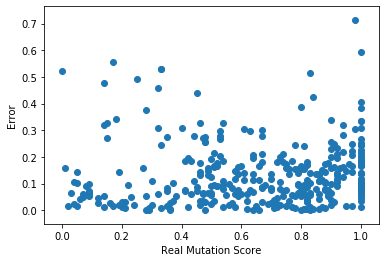

In [85]:
>>> plt.scatter(*zip(*list(zip(y_testi,err))))
plt.ylabel('Error')
plt.xlabel('Real Mutation Score')
plt.show()
>>> plt.show()

In [67]:
import statistics

err = y_test - y_pred
err = np.concatenate(abs(err).tolist())
statistics.mean(err)

0.29231237044845093